# TDoA Simulation Notebook
This notebook contains a self-contained version of the TDoA simulation.
All functions are pasted directly (no local imports).

It reproduces the logic from the repository's `simulation/tdoa_sim.py` using the solver and utilities inlined here.

In [1]:
# Core imports
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# TDoA solver (pasted from localization/core.py)
def tdoa_pairwise_residual(x, nodes, pairs, c=3e8):
    """Residuals for pairwise TDoA constraints.

    For each (i, j, dt):
        ||x - nodes[i]|| - ||x - nodes[j]||  -  c*dt
    Returns residuals in meters.
    """
    x = np.asarray(x, dtype=float)
    nodes = np.asarray(nodes, dtype=float)

    r = np.empty(len(pairs), dtype=float)
    for k, (i, j, dt) in enumerate(pairs):
        di = np.linalg.norm(x - nodes[i])
        dj = np.linalg.norm(x - nodes[j])
        r[k] = (di - dj) - c * dt
    return r

def solve_tdoa_pairwise(nodes, pairs, c=3e8, x0=None, loss="soft_l1"):
    """Estimate TX position from pairwise TDoA delays.

    nodes: (N, D) array
    pairs: iterable of (i, j, dt_seconds)
    """
    nodes = np.asarray(nodes, dtype=float)

    if x0 is None:
        x0 = nodes.mean(axis=0)

    fun = lambda x: tdoa_pairwise_residual(x, nodes, pairs, c=c)
    res = least_squares(fun, x0, loss=loss)
    return res.x, res

In [3]:
# Utilities (pasted from utils/tdoa_utils.py)
from typing import Iterable, List, Optional, Sequence, Tuple

def generate_pairwise_tdoa(
    nodes: np.ndarray,
    tx_pos: np.ndarray,
    pairs: Optional[Iterable[Tuple[int, int]]] = None,
    c: float = 3e8,
    sigma_t: float = 0.0,
    seed: Optional[int] = None,
) -> List[Tuple[int, int, float]]:
    """Generate pairwise TDoA (i, j, dt_seconds) entries.

    - nodes: (N,2) array of anchor positions (meters)
    - tx_pos: (2,) transmitter position (meters)
    - pairs: optional iterable of (i,j); if None, uses all i<j
    - c: speed of propagation (m/s)
    - sigma_t: standard deviation of additive Gaussian noise on dt (seconds)
    - seed: RNG seed

    Returns list of tuples (i, j, dt_seconds) where dt = toa_i - toa_j (seconds).
    """
    nodes = np.asarray(nodes, dtype=float)
    tx_pos = np.asarray(tx_pos, dtype=float)
    if pairs is None:
        N = nodes.shape[0]
        pairs = [(i, j) for i in range(N) for j in range(i + 1, N)]

    rng = np.random.default_rng(seed)
    d = np.linalg.norm(nodes - tx_pos, axis=1)  # distances (m)
    toas = d / float(c)  # seconds

    out: List[Tuple[int, int, float]] = []
    for (i, j) in pairs:
        dt = float(toas[i] - toas[j])  # seconds
        if sigma_t and sigma_t > 0.0:
            dt = dt + float(rng.normal(scale=float(sigma_t)))
        out.append((int(i), int(j), float(dt)))
    return out

def get_bounds_from_nodes(
    nodes: np.ndarray,
    extra_points: Optional[Sequence[np.ndarray]] = None,
    margin: float = 0.6,
    min_margin: float = 5.0,
) -> Tuple[float, float, float, float]:
    nodes = np.asarray(nodes, dtype=float)
    pts = [nodes]
    if extra_points:
        for p in extra_points:
            pts.append(np.atleast_2d(np.asarray(p, dtype=float)))

    all_pts = np.vstack(pts)
    mins = all_pts.min(axis=0)
    maxs = all_pts.max(axis=0)
    span = maxs - mins

    m = np.maximum(span * float(margin), float(min_margin))
    xmin, ymin = mins - m
    xmax, ymax = maxs + m
    return float(xmin), float(xmax), float(ymin), float(ymax)

def hyperbola_field_2d(
    ni: np.ndarray,
    nj: np.ndarray,
    dt: float,
    c: float = 3e8,
    xlim: Tuple[float, float] = (-50.0, 50.0),
    ylim: Tuple[float, float] = (-30.0, 30.0),
    grid: int = 600,
):
    ni = np.asarray(ni, dtype=float)
    nj = np.asarray(nj, dtype=float)
    xmin, xmax = float(xlim[0]), float(xlim[1])
    ymin, ymax = float(ylim[0]), float(ylim[1])

    xs = np.linspace(xmin, xmax, int(grid))
    ys = np.linspace(ymin, ymax, int(grid))
    X, Y = np.meshgrid(xs, ys)
    di = np.sqrt((X - ni[0]) ** 2 + (Y - ni[1]) ** 2)
    dj = np.sqrt((X - nj[0]) ** 2 + (Y - nj[1]) ** 2)
    Z = (di - dj) - (float(c) * float(dt))
    return X, Y, Z

def plot_hyperbola_2d(
    ax,
    ni: np.ndarray,
    nj: np.ndarray,
    dt: float,
    c: float = 3e8,
    xlim: Tuple[float, float] = (-50.0, 50.0),
    ylim: Tuple[float, float] = (-30.0, 30.0),
    grid: int = 600,
    alpha: float = 0.35,
):
    X, Y, Z = hyperbola_field_2d(ni, nj, dt, c=c, xlim=xlim, ylim=ylim, grid=grid)
    cs = ax.contour(X, Y, Z, levels=[0.0], linewidths=1.0, alpha=float(alpha), colors="red")
    return cs

def generate_signal(fs: float, duration: float, f0: float, phase: float = 0.0) -> np.ndarray:
    t = np.arange(int(np.round(fs * duration))) / float(fs)
    sig = np.exp(2j * np.pi * float(f0) * t + 1j * float(phase))
    return sig.astype(np.complex64)

In [4]:
# Simulation runner (adapted from simulation/tdoa_sim.py)
from typing import List, Tuple

def all_pairs(n: int) -> List[Tuple[int, int]]:
    return [(i, j) for i in range(n) for j in range(i + 1, n)]

def plot_scene(
    nodes: np.ndarray,
    true_pos: np.ndarray,
    est_pos: np.ndarray,
    pairs_dt: List[Tuple[int, int, float]],
    show_hyperbolas: bool = True,
) -> None:
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(nodes[:, 0], nodes[:, 1], c="C0", marker="o", label="nodes")
    for k, p in enumerate(nodes):
        ax.text(p[0] + 0.3, p[1] + 0.3, f"N{k}", color="C0")
    ax.scatter([true_pos[0]], [true_pos[1]], c="C1", marker="*", s=120, label="true TX")
    ax.scatter([est_pos[0]], [est_pos[1]], c="C2", marker="x", s=80, label="estimate")
    ax.legend()
    ax.set_aspect("auto")
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    ax.set_title("TDoA simulation")

    if show_hyperbolas:
        xmin, xmax, ymin, ymax = get_bounds_from_nodes(nodes, extra_points=(true_pos, est_pos))
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        nx_ticks = 10
        xticks = np.linspace(xmin, xmax, nx_ticks + 1)
        yticks = np.linspace(ymin, ymax, nx_ticks + 1)
        ax.set_xticks(xticks)
        ax.set_yticks(yticks)
        ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.45)

        for (i, j, dt) in pairs_dt:
            try:
                plot_hyperbola_2d(
                    ax,
                    nodes[i],
                    nodes[j],
                    dt,
                    c=3e8,
                    xlim=(xmin, xmax),
                    ylim=(ymin, ymax),
                    grid=600,
                    alpha=0.25,
                )
            except Exception:
                pass

    plt.tight_layout()
    plt.show()

def main(show_hyperbolas=True):
    # example anchors (meters) - a rectangle / square
    nodes = np.array([[ -20.0, -10.0],
                      [  20.0, -10.0],
                      [  20.0,  10.0],
                      [ -20.0,  10.0 ]])

    # true transmitter position (drone)
    true_pos = np.array([-10, -100])

    pairs = all_pairs(nodes.shape[0])

    sigma_t = 5e-11
    pairs_dt = generate_pairwise_tdoa(nodes, true_pos, pairs=pairs, c=3e8, sigma_t=sigma_t, seed=0)

    est_pos, res = solve_tdoa_pairwise(nodes, pairs_dt, c=3e8, x0=None, loss="soft_l1")

    err_m = float(np.linalg.norm(est_pos - true_pos))
    print(f"true position: {true_pos}")
    print(f"estimated   : {est_pos}")
    print(f"position error (m): {err_m:.3f}")

    plot_scene(nodes, true_pos, est_pos, pairs_dt, show_hyperbolas=show_hyperbolas)

true position: [ -10 -100]
estimated   : [ -10.01326989 -100.15834331]
position error (m): 0.159


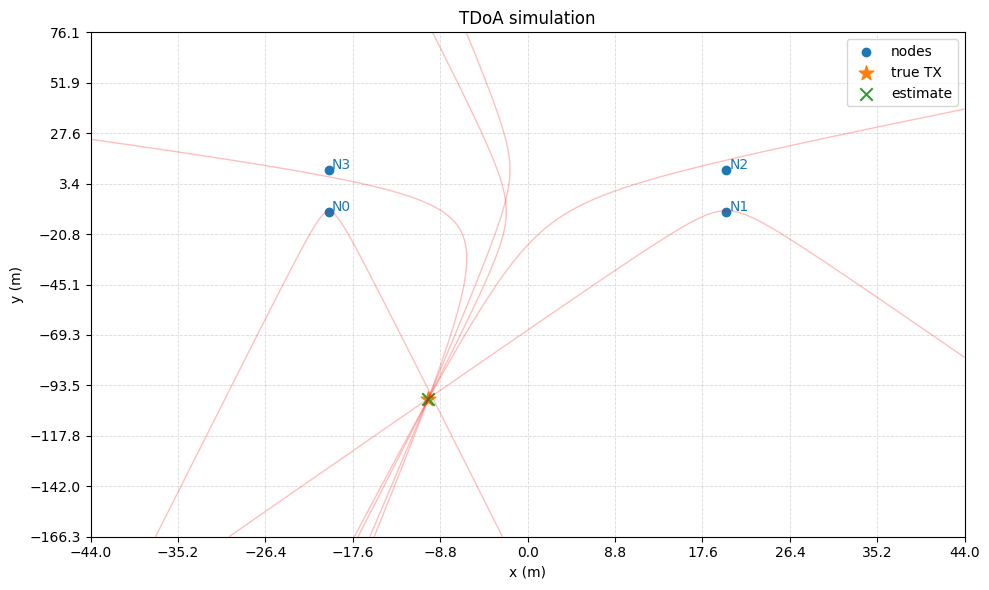

In [5]:
# Run the simulation (inline plotting)
main(show_hyperbolas=True)